# phospho Intent Embed

This notebooks enables you to reproduce the results of the technical paper "INTENT EMBED: CAPTURING USER INTENTION IN DENSE VECTOR REPRESENTATIONS FOR ENHANCED LLM INTERACTION" available [here](https://research.phospho.ai/phospho_intent_embed.pdf)

In [29]:
# Install the required packages
!pip install python-dotenv numpy openai asyncio nest_asyncio scikit-learn pandas seaborn tqdm
!pip install --upgrade phospho


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [27]:
# Check for API keys
import os
from dotenv import load_dotenv
import numpy as np
import nest_asyncio
from phospho import lab
import asyncio
import pandas as pd
from tqdm import tqdm

load_dotenv('../.env') # Change by the path to your .env file

assert 'OPENAI_API_KEY' in os.environ, 'OPENAI_API_KEY not found in environment variables'
assert 'PHOSPHO_API_KEY' in os.environ, 'PHOSPHO_API_KEY not found in environment variables'

In [3]:
import requests

def get_wikipedia_article_text(title):
    """
    Get a Wikipedia article by its title.
    """
    # Construct the API request URL
    url = f"https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "extracts",
        "exintro": True,
        "explaintext": True,
        "format": "json",
        "titles": title
    }
    
    # Make the request
    response = requests.get(url, params=params)
    
    # Parse the JSON response
    data = response.json()
    
    # Extract the page content
    pages = data["query"]["pages"]
    page = next(iter(pages.values()))
    text = page.get("extract", "No content found")
    
    return text

In [4]:
print(get_wikipedia_article_text("Paris"))

Paris is the capital and largest city of France. With an official estimated population of 2,102,650 residents as of 1 January 2023 in an area of more than 105 km2 (41 sq mi), Paris is the fourth-largest city in the European Union and the 30th most densely populated city in the world in 2022. Since the 17th century, Paris has been one of the world's major centres of finance, diplomacy, commerce, culture, fashion, and gastronomy. For its leading role in the arts and sciences, as well as its early and extensive system of street lighting, in the 19th century, it became known as the City of Light. 
The City of Paris is the centre of the Île-de-France region, or Paris Region, with an official estimated population of 12,271,794 inhabitants on 1 January 2023, or about 19% of the population of France. The Paris Region had a GDP of €765 billion (US$1.064 trillion, PPP) in 2021, the highest in the European Union. According to the Economist Intelligence Unit Worldwide Cost of Living Survey, in 202

In [28]:
def get_random_wikipedia_titles(limit=100):
    """
    Get a list of random Wikipedia article titles.
    Might be slow as we perform one request per article to avoid rate limiting.
    """

    # Construct the API request URL
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "list": "random",
        "rnnamespace": 0,
        "rnlimit": limit,
        "format": "json"
    }
    
    # Make the request
    response = requests.get(url, params=params)
    
    # Parse the JSON response
    data = response.json()
    
    # Extract the titles
    titles = [article["title"] for article in data["query"]["random"]]
    
    return titles

def get_random_wikipedia_articles(limit=100) -> list:
    """
    Get a list of random Wikipedia articles.
    """

    titles = get_random_wikipedia_titles(limit)
    articles = []
    for i in tqdm(range(0, len(titles))):
        article = get_wikipedia_article_text(titles[i])
        articles.append(article)
    return articles

In [6]:
get_random_wikipedia_articles(limit=2)

100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


['Lisbee Stainton (born 1988, Hampshire) is an English singer-songwriter with a folk acoustic style and known for her use of a distinctive eight-string guitar.',
 "The 2023 QAFLW season was the 23rd season of the QAFL Women's (QAFLW), the highest-level senior women's Australian rules football competition in Queensland. The season featured eight clubs, beginning on 15 April and concluding on 27 August.\nThe premiership was won by Bond University for the first time, after defeating Aspley by 49 points in the 2023 QAFLW Grand Final."]

In [7]:
# Get 1k random Wikipedia articles
wikipedia_articles_text = get_random_wikipedia_articles(limit=334)

# Add instruction prompts
wikipedia_articles_text_generate_title = [text + "\n\nGenerate a title for this text." for text in wikipedia_articles_text]
wikipedia_articles_is_software = [text + "\n\nIs this a good text to include in my Computer Science course?" for text in wikipedia_articles_text]
wikipedia_articles_police = [text + "\n\nI just got the text above in the mail. I want to call the Police. Do it NOW." for text in wikipedia_articles_text]

100%|██████████| 334/334 [02:50<00:00,  1.96it/s]


In [8]:
print(f"Total number of articles: {len(wikipedia_articles_text)}")
print(f"Total number of articles with instruction prompts: {len(wikipedia_articles_text_generate_title) + len(wikipedia_articles_is_software) + len(wikipedia_articles_police)}")

Total number of articles: 334
Total number of articles with instruction prompts: 1002


## Generate embeddings

As the phospho embedding API doesn't accept batched inputs for now, we will use phospsho lab asynchronous workload manager to generate the embeddings in a fast way.

In [9]:
from openai import OpenAI, AsyncOpenAI

# We use sync clients
openai_client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])
# We use the openai client also for phospho, as the embeddings endpoint is OpenAI comapatible
phospho_client = AsyncOpenAI(api_key=os.environ['PHOSPHO_API_KEY'], base_url='https://api.phospho.ai/v2')

In [10]:
def generate_openai_embeddings(texts: list) -> np.ndarray:
    """
    Generate embeddings for a list of texts using the OpenAI API.
    """
    embeddings = []
    BATCH_SIZE = 2048  # Adjust this based on your average sentence length

    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i + BATCH_SIZE]
        embeddings_response = openai_client.embeddings.create(
            model="text-embedding-3-small",
            input=batch,
            encoding_format="float"
        )

        for embedding_data in embeddings_response.data:
            embeddings.append(embedding_data.embedding)


    return np.array(embeddings)

In [12]:
async def embedding_job(message: lab.Message) -> lab.JobResult:
    # This line calls the phospho API to get the embeddings
    embedding_response = await phospho_client.embeddings.create(
            model="intent-embed",
            input=message.content
        )
    embedding_vector = embedding_response.data[0].embedding
    return lab.JobResult(
        value=embedding_vector,
        result_type=lab.ResultType.list
    )

In [13]:
nest_asyncio.apply() # for use with Jupyter notebooks

def generate_phospho_intent_embeddings(texts: list[str]) -> np.ndarray:
    """
    We use the phospho lab to handle the multiple async requests
    """
    print(f"encoding {len(texts)} sentences")
    messages = [
        lab.Message(
            id=str(i),
            role="user",
            content=texts[i],
        )
        for i in range(len(texts))
    ]

    workload = lab.Workload(jobs=[lab.Job(id="encoding", job_function=embedding_job)])
    asyncio.run(workload.async_run(messages, max_parallelism=200))

    embeddings = []
    for i in range(len(texts)):
        embedding = workload.results[str(i)]['encoding'].value
        embeddings.append(embedding)

    return np.array(embeddings)

In [14]:
# Generate embeddings for the Wikipedia articles with instruction prompts

wikipedia_phospho_embeddings_generate_title = generate_phospho_intent_embeddings(wikipedia_articles_text_generate_title)
wikipedia_openai_embeddings_generate_title = generate_openai_embeddings(wikipedia_articles_text_generate_title)

wikipedia_phospho_embeddings_is_software = generate_phospho_intent_embeddings(wikipedia_articles_is_software)
wikipedia_openai_embeddings_is_software = generate_openai_embeddings(wikipedia_articles_is_software)

wikipedia_phospho_embeddings_police = generate_phospho_intent_embeddings(wikipedia_articles_police)
wikipedia_openai_embeddings_police = generate_openai_embeddings(wikipedia_articles_police)

No job_config provided. Running with empty config


encoding 334 sentences


100%|██████████| 334/334 [00:37<00:00,  8.86it/s]
No job_config provided. Running with empty config


encoding 334 sentences


100%|██████████| 334/334 [00:11<00:00, 28.25it/s]
No job_config provided. Running with empty config


encoding 334 sentences


100%|██████████| 334/334 [00:16<00:00, 20.09it/s]


In [16]:
X_phospho = np.concatenate([wikipedia_phospho_embeddings_generate_title, wikipedia_phospho_embeddings_is_software, wikipedia_phospho_embeddings_police], axis=0)
X_openai = np.concatenate([wikipedia_openai_embeddings_generate_title, wikipedia_openai_embeddings_is_software, wikipedia_openai_embeddings_police], axis=0)
y_labels = np.array( [0] * 334 + [1] * 334 + [2] * 334  ) # 0: generate title, 1: is software, 2: police

# Scores

In [30]:
# Compute silhouette score of the phospho embeddings on title and code
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

print("Calinski Harabasz score (higher is better)")    
print(f"phospho: {calinski_harabasz_score(X_phospho, y_labels)}")
print(f"openai: {calinski_harabasz_score(X_openai, y_labels)}")
print("")
print("Davies Bouldin score (lower is better)")
print(f"phospho: {davies_bouldin_score(X_phospho, y_labels)}")
print(f"openai: {davies_bouldin_score(X_openai, y_labels)}")

Calinski Harabasz score (higher is better)
phospho: 175.5301720149413
openai: 47.624135391734825

Davies Bouldin score (lower is better)
phospho: 2.2527192866592203
openai: 4.192310586696032


# Vectors 2d visualization

/var/folders/gz/lrcxkdnn5ydgwk5ktv0ygm600000gn/T/ipykernel_34191/1242515713.py:22: UserWarning: The palette list has more values (1002) than needed (3), which may not be intended.
  sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2', hue='User Intent', palette=sns.color_palette("muted", len(y_labels)))


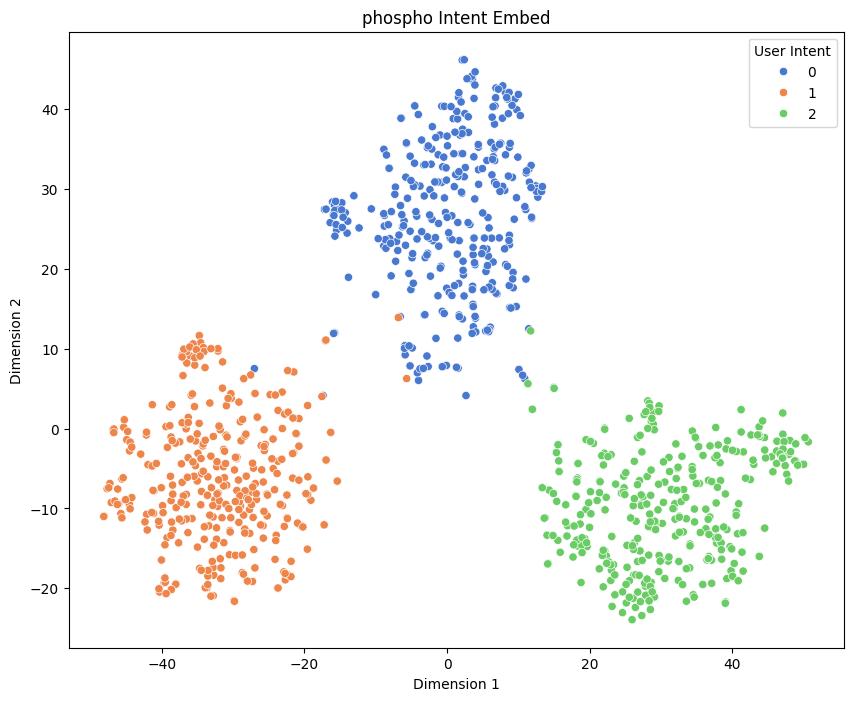

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

# First apply PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_phospho)

# Apply t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)

# Create a DataFrame for seaborn
df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2'])
df['User Intent'] = y_labels.tolist()

# Plot the data
plt.figure(figsize=(10, 8))
plt.title("phospho Intent Embed")
sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2', hue='User Intent', palette=sns.color_palette("muted", len(y_labels)))
plt.show()

/var/folders/gz/lrcxkdnn5ydgwk5ktv0ygm600000gn/T/ipykernel_34191/2545060768.py:16: UserWarning: The palette list has more values (1002) than needed (3), which may not be intended.
  sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2', hue='User Intent', palette=sns.color_palette("muted", len(y_labels)))


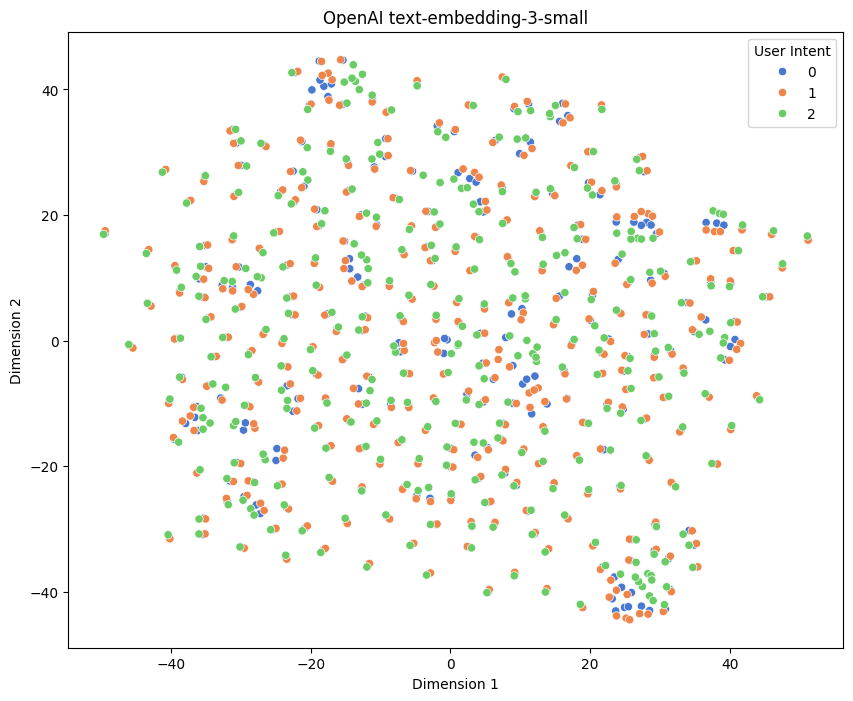

In [32]:
# Apply PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_openai)

# Apply t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)

# Create a DataFrame for seaborn
df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2'])
df['User Intent'] = y_labels.tolist()

# Plot the data
plt.figure(figsize=(10, 8))
plt.title("OpenAI text-embedding-3-small")
sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2', hue='User Intent', palette=sns.color_palette("muted", len(y_labels)))
plt.show()

# Learn more about phospho

See the [phospho documentation](https://phospho-app.github.io/docs/) for more information on how to use phospho.
Check out the [embeddings documentation](https://phospho-app.github.io/docs/models/embeddings) for more information on how to use embeddings.